In [1]:
import os
import glob
import ntpath
import textwrap
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import util

# load data

In [3]:
# load csv file that contains the measures
fn_thk = '/Path/Gordon333_Harmonized_corrThickness_proc202108_N443.csv'
fn_myl = '/Path/Gordon333_Harmonized_SmoothedMyelinMap_proc202108_N443.csv'
fn_fc = '/Path/Gordon333_Harmonized_FC_fix_bp_gsr_proc202108_N443.csv'

myl_df = pd.read_csv(fn_myl, index_col=0, low_memory=False)
thk_df = pd.read_csv(fn_thk, index_col=0, low_memory=False)
dm_fc_df = pd.read_csv(fn_fc, index_col=0, low_memory=False)

# take the log (important!)
myl_df = np.log(myl_df)

print('myl_df.shape: ', myl_df.shape)
print('thk_df.shape: ', thk_df.shape)
print('dm_fc_df.shape: ', dm_fc_df.shape)

myl_df.shape:  (443, 333)
thk_df.shape:  (443, 333)
dm_fc_df.shape:  (443, 55278)


In [5]:
fn_demo = '/Path/All-Measures-BAR-Harmonized-nocovar-demographics.csv'
demo_df = pd.read_csv(fn_demo, index_col = 0)

subj_list = myl_df.index
n_subj = len(subj_list)
age_df = demo_df.loc[subj_list,['Age']]

myl_df.shape:  (443, 333)
thk_df.shape:  (443, 333)
dm_fc_df.shape:  (443, 55278)
age_df.shape:  (443, 1)


In [13]:
print('mean age:', age_df['Age'].mean())
print('std age:', age_df['Age'].std())
print('N_male:', demo_df[demo_df['Gender']==1].shape[0])
print('N_female:', demo_df[demo_df['Gender']==2].shape[0])
print('N_skk:', demo_df[demo_df['Site']==1].shape[0])
print('N_sku:', demo_df[demo_df['Site']==2].shape[0])

mean age: 12.286704288939054
std age: 1.578102982449769
N_male: 252
N_female: 191
N_skk: 375
N_sku: 68


# helper function

In [7]:
def demean(df):
    mean_df = df.mean(axis = 1)
    demean_df = df.sub(mean_df, axis = 'index')
    return demean_df

# regress out age effect
def age_residual_voxel(to_reg_df, age_df):
    age_const_df = age_df.copy()
    age_const_df.loc[:,'const'] = np.ones((age_df.shape[0], 1))
    Y = to_reg_df.values
    X = age_const_df.values
    coef, res, rank, s = np.linalg.lstsq(X, Y, rcond = None)

    reg_mat = to_reg_df.values - np.matmul(age_const_df.values, coef) # remove age and const terms
    reg_df = pd.DataFrame(reg_mat, index=to_reg_df.index, columns=to_reg_df.columns)
    coef_df = pd.DataFrame(coef.T, index=to_reg_df.columns, columns=age_const_df.columns)
    return reg_df, coef_df

# regress out age effect
def confound_residual(to_reg_df, confound_df):
    confound_const_df = confound_df.copy()
    confound_const_df.loc[:,'const'] = np.ones((age_df.shape[0], 1))
    Y = to_reg_df.values
    X = confound_const_df.values
    coef, res, rank, s = np.linalg.lstsq(X, Y, rcond = None)

    co_var = confound_const_df.iloc[:,:-2]
    co_var = co_var.sub(co_var.mean(axis=0), axis=1).values
    reg_mat = to_reg_df.values - np.matmul(co_var, coef[:-2,:]) # remove confound terms + mean term
        
    reg_df = pd.DataFrame(reg_mat, index=to_reg_df.index, columns=to_reg_df.columns)
    coef_df = pd.DataFrame(coef.T, index=to_reg_df.columns, columns=confound_const_df.columns)
    return reg_df, coef_df

# function : transform FC from vector to matrix
import re
def fc_vec2mat_gordon333(fcvec_df):
    # obtain roi list
    conn_list = fcvec_df.index.values
    roi_list = [re.sub(':.*','',conn_list[0])] + [re.sub('.*:','',ss) for ss in conn_list[:332]]
    print('# of rois: ' + str(len(roi_list)))
    
    n_roi = len(roi_list)
    idx = np.triu_indices(n_roi,1)
    fc_mtx = np.zeros((n_roi,n_roi))
    fc_mtx[idx] = fcvec_df.values
    fc_mtx = fc_mtx + fc_mtx.T
    np.fill_diagonal(fc_mtx, 1)
    
    return pd.DataFrame(fc_mtx, index = roi_list, columns = roi_list)

def sort_lr(df):
    df_l = df.filter(regex = '^L_.*', axis = 'columns')
    df_r = df.filter(regex = '^R_.*', axis = 'columns')
    df2 = pd.concat([df_l, df_r], axis = 1)
    
    df_l2 = df2.filter(regex = '^L_.*', axis = 'index')
    df_r2 = df2.filter(regex = '^R_.*', axis = 'index')
    sorted_df = pd.concat([df_l2, df_r2], axis = 0)
    
    return sorted_df

def show_matrix(mtx, vrange, cmap):
    vmin, vmax = vrange
#     plt.figure(figsize = (8, 8))
    plt.figure()
    im = plt.imshow(mtx, cmap = cmap, vmin = vmin, vmax =vmax)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
def upper_tri_masking(A):
    # get the upper triangle of matrix without diagonal
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

# age-coef brain maps

In [8]:
_, age_coef_thk = age_residual_voxel(thk_df, age_df)
_, age_coef_myl = age_residual_voxel(myl_df, age_df)

age_coef_thk = age_coef_thk['Age']
age_coef_myl = age_coef_myl['Age']

coef.shape: (2, 333)
coef.shape: (2, 333)


In [9]:
age_coef_thk.to_csv('age_coef_Gordon333_orig_thk_n{}.csv'.format(n_subj))
age_coef_myl.to_csv('age_coef_Gordon333_orig_myl_n{}.csv'.format(n_subj))

util.wbview_gordon333_saveas_dscalar('age_coef_Gordon333_orig_thk_n{}.csv'.format(n_subj))
util.wbview_gordon333_saveas_dscalar('age_coef_Gordon333_orig_myl_n{}.csv'.format(n_subj))

# correlation matrix - all subjects

coef.shape: (2, 333)
coef.shape: (2, 333)
coef.shape: (3, 55278)
# of rois: 333


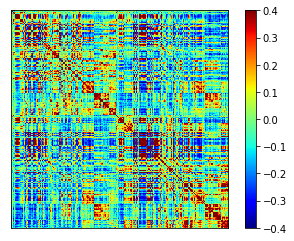

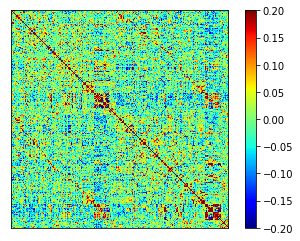

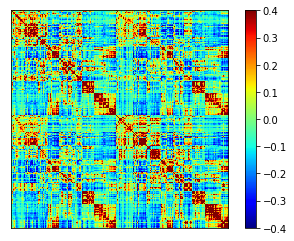

In [11]:
covar1_df = demo_df.loc[:,['Gender','Mean RMS Motion']] # after harmonization
covar2_df = demo_df.loc[:,['Gender']]

resid_dm_myl_df, _ = confound_residual(demean(myl_df), covar2_df)
resid_dm_thk_df, _ = confound_residual(demean(thk_df), covar2_df)
resid_dm_fc_df, _ = confound_residual(dm_fc_df, covar1_df)

dm_myl_corr_mtx = sort_lr(resid_dm_myl_df.corr())
show_matrix(dm_myl_corr_mtx, (-0.4, 0.4), 'jet')
plt.savefig('gordon333_matrix_myelin_n{}.pdf'.format(n_subj), bbox_inches = 'tight')

dm_thk_corr_mtx = sort_lr(resid_dm_thk_df.corr())
show_matrix(dm_thk_corr_mtx, (-0.2, 0.2), 'jet')
plt.savefig('gordon333_matrix_thickness_n{}.pdf'.format(n_subj), bbox_inches = 'tight')

dm_fc_mtx = sort_lr(fc_vec2mat_gordon333(resid_dm_fc_df.mean(axis = 0)))
show_matrix(dm_fc_mtx, (-0.4, 0.4), 'jet')
plt.savefig('gordon333_matrix_FC_n{}.pdf'.format(n_subj), bbox_inches = 'tight')

coef.shape: (2, 333)
coef.shape: (2, 333)


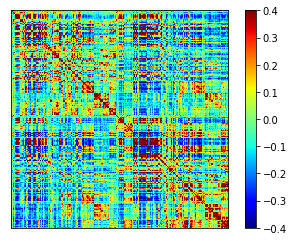

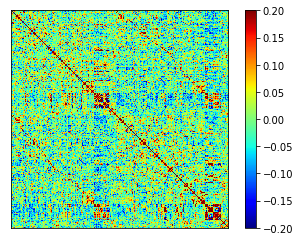

In [19]:
reg_dm_myl_df, _ = age_residual_voxel(demean(myl_df), age_df)
reg_myl_corr_mtx = sort_lr(reg_dm_myl_df.corr())
show_matrix(reg_myl_corr_mtx, (-0.4, 0.4), 'jet')

reg_dm_thk_df, _ = age_residual_voxel(demean(thk_df), age_df)
reg_thk_corr_mtx = sort_lr(reg_dm_thk_df.corr())
show_matrix(reg_thk_corr_mtx, (-0.2, 0.2), 'jet')

# meta-correlation - all subjects

In [20]:
# calculate corr across rois
mf_metacorr = dm_myl_corr_mtx.corrwith(dm_fc_mtx, axis=0)
mt_metacorr = dm_myl_corr_mtx.corrwith(dm_thk_corr_mtx, axis=0)
tf_metacorr = dm_thk_corr_mtx.corrwith(dm_fc_mtx, axis=0)

mf_metacorr.to_csv('gordon333_metacorr_dmMdmF_n{}.csv'.format(n_subj))
mt_metacorr.to_csv('gordon333_metacorr_dmMdmT_n{}.csv'.format(n_subj))
tf_metacorr.to_csv('gordon333_metacorr_dmTdmF_n{}.csv'.format(n_subj))

util.wbview_gordon333_saveas_dscalar('gordon333_metacorr_dmMdmF_n{}.csv'.format(n_subj))
util.wbview_gordon333_saveas_dscalar('gordon333_metacorr_dmMdmT_n{}.csv'.format(n_subj))
util.wbview_gordon333_saveas_dscalar('gordon333_metacorr_dmTdmF_n{}.csv'.format(n_subj))

In [21]:
# calculate corr across rois
reg_mf_metacorr = reg_myl_corr_mtx.corrwith(dm_fc_mtx, axis=0)
reg_mt_metacorr = reg_myl_corr_mtx.corrwith(reg_thk_corr_mtx, axis=0)
reg_tf_metacorr = reg_thk_corr_mtx.corrwith(dm_fc_mtx, axis=0)

reg_mf_metacorr.to_csv('gordon333_metacorr_dmMdmF_age-regressed_n{}.csv'.format(n_subj))
reg_mt_metacorr.to_csv('gordon333_metacorr_dmMdmT_age-regressed_n{}.csv'.format(n_subj))
reg_tf_metacorr.to_csv('gordon333_metacorr_dmTdmF_age-regressed_n{}.csv'.format(n_subj))

util.wbview_gordon333_saveas_dscalar('gordon333_metacorr_dmMdmF_age-regressed_n{}.csv'.format(n_subj))
util.wbview_gordon333_saveas_dscalar('gordon333_metacorr_dmMdmT_age-regressed_n{}.csv'.format(n_subj))
util.wbview_gordon333_saveas_dscalar('gordon333_metacorr_dmTdmF_age-regressed_n{}.csv'.format(n_subj))

# correlation matrix reproducibility - random split

## helper function

In [22]:
import statsmodels.api as sm

def reproducibility_matrix(mat1, mat2):
    x = upper_tri_masking(mat1.values)
    y = upper_tri_masking(mat2.values)

    xc = sm.add_constant(x)
    mdl = sm.OLS(y, xc)
    est = mdl.fit()
    # print(est.summary())
    # print('r = ', np.sqrt(est.rsquared))
    return np.sqrt(est.rsquared)

def reproducibility_metacorr(metacorr1, metacorr2):
    x = metacorr1.values
    y = metacorr2.values

    xc = sm.add_constant(x)
    mdl = sm.OLS(y, xc)
    est = mdl.fit()
    # print(est.summary())
    # print('r = ', np.sqrt(est.rsquared))
    return np.sqrt(est.rsquared)

def metacorr_map(cormat1, cormat2, fn_sub, grp, n_grp):
    metacorr = cormat1.corrwith(cormat2, axis = 0)
    
    fn_csv = 'gordon333_{}_metacorr_confoundreg_{}_n{}.csv'.format(fn_sub, grp, n_grp)
    metacorr.to_csv(fn_csv)
    util.wbview_gordon333_saveas_dscalar(fn_csv)
    
    return metacorr

In [23]:
# random split
np.random.seed(64537) # reproducible
sample = np.arange(len(subj_list))
array1 = np.random.choice(sample, np.floor(len(sample)/2).astype(int), replace = False)
array1 = np.sort(array1)
array2 = np.setxor1d(sample, array1)

subj_grp1 = subj_list[array1]
subj_grp2 = subj_list[array2]

grp1, n_grp1 = 'random1', len(subj_grp1)
grp2, n_grp2 = 'random2', len(subj_grp2)

In [24]:
# correlation matrices of subgroups
myl_grp1_cormat = demean(myl_df.loc[subj_grp1, :]).corr()
myl_grp2_cormat = demean(myl_df.loc[subj_grp2, :]).corr()

thk_grp1_cormat = demean(thk_df.loc[subj_grp1, :]).corr()
thk_grp2_cormat = demean(thk_df.loc[subj_grp2, :]).corr()

fc_grp1_cormat = fc_vec2mat_gordon333(dm_fc_df.loc[subj_grp1, :].mean(axis = 0))
fc_grp2_cormat = fc_vec2mat_gordon333(dm_fc_df.loc[subj_grp2, :].mean(axis = 0))

# of rois: 333
# of rois: 333


In [25]:
print('Reproducibility - random split')
r = reproducibility_matrix(myl_grp1_cormat, myl_grp2_cormat)
print('{}: r = {:.2f}'.format('Myelin',r))
r = reproducibility_matrix(thk_grp1_cormat, thk_grp2_cormat)
print('{}: r = {:.2f}'.format('Thickness',r))
r = reproducibility_matrix(fc_grp1_cormat, fc_grp2_cormat)
print('{}: r = {:.2f}'.format('FC',r))

Reproducibility - random split
Myelin: r = 0.84
Thickness: r = 0.42
FC: r = 1.00


# meta-correlation reproducibility - random split

In [27]:
# correlation matrices of subgroups
myl_grp1_cormat = demean(myl_df.loc[subj_grp1, :]).corr()
myl_grp2_cormat = demean(myl_df.loc[subj_grp2, :]).corr()

thk_grp1_cormat = demean(thk_df.loc[subj_grp1, :]).corr()
thk_grp2_cormat = demean(thk_df.loc[subj_grp2, :]).corr()

fc_grp1_cormat = fc_vec2mat_gordon333(dm_fc_df.loc[subj_grp1, :].mean(axis = 0))
fc_grp2_cormat = fc_vec2mat_gordon333(dm_fc_df.loc[subj_grp2, :].mean(axis = 0))

# of rois: 333
# of rois: 333


In [28]:
mfmc_grp1 = metacorr_map(myl_grp1_cormat, fc_grp1_cormat, 'dmMdmF', grp1, n_grp1)
mfmc_grp2 = metacorr_map(myl_grp2_cormat, fc_grp2_cormat, 'dmMdmF', grp2, n_grp2)

mtmc_grp1 = metacorr_map(myl_grp1_cormat, thk_grp1_cormat, 'dmMdmT', grp1, n_grp1)
mtmc_grp2 = metacorr_map(myl_grp2_cormat, thk_grp2_cormat, 'dmMdmT', grp2, n_grp2)

tfmc_grp1 = metacorr_map(thk_grp1_cormat, fc_grp1_cormat, 'dmTdmF', grp1, n_grp1)
tfmc_grp2 = metacorr_map(thk_grp2_cormat, fc_grp2_cormat, 'dmTdmF', grp2, n_grp2)

In [29]:
print('Reproducibility - random split')
r = reproducibility_metacorr(mfmc_grp1, mfmc_grp2)
print('{}: r = {:.2f}'.format('MFMC',r))
r = reproducibility_metacorr(mtmc_grp1, mtmc_grp2)
print('{}: r = {:.2f}'.format('MTMC',r))
r = reproducibility_metacorr(tfmc_grp1, tfmc_grp2)
print('{}: r = {:.2f}'.format('TFMC',r))

Reproducibility - random split
MFMC: r = 0.87
MTMC: r = 0.56
TFMC: r = 0.62


# meta-correlation reproducibility - age split

In [31]:
# age split
median_age = np.median(age_df['Age'].values)

subj_grp1 = subj_list[age_df['Age'] < median_age] # young
subj_grp2 = subj_list[age_df['Age'] > median_age] # old

subj_grpx = subj_list[age_df['Age'] == median_age] # young
np.random.seed(64537) # reproducible
sample = np.arange(len(subj_grpx))
array1 = np.random.choice(sample, np.floor(len(sample)/2).astype(int), replace = False)
array1 = np.sort(array1)
array2 = np.setxor1d(sample, array1)
subj_grp1 = subj_grp1.append(subj_grpx[array1])
subj_grp2 = subj_grp2.append(subj_grpx[array2])

grp1, n_grp1 = 'yng', len(subj_grp1)
grp2, n_grp2 = 'old', len(subj_grp2)

In [33]:
# correlation matrices of subgroups
myl_grp1_cormat = resid_dm_myl_df.loc[subj_grp1, :].corr()
myl_grp2_cormat = resid_dm_myl_df.loc[subj_grp2, :].corr()

thk_grp1_cormat = resid_dm_thk_df.loc[subj_grp1, :].corr()
thk_grp2_cormat = resid_dm_thk_df.loc[subj_grp2, :].corr()

fc_grp1_cormat = fc_vec2mat_gordon333(resid_dm_fc_df.loc[subj_grp1, :].mean(axis = 0))
fc_grp2_cormat = fc_vec2mat_gordon333(resid_dm_fc_df.loc[subj_grp2, :].mean(axis = 0))

# of rois: 333
# of rois: 333


In [34]:
mfmc_grp1 = metacorr_map(myl_grp1_cormat, fc_grp1_cormat, 'dmMdmF', grp1, n_grp1)
mfmc_grp2 = metacorr_map(myl_grp2_cormat, fc_grp2_cormat, 'dmMdmF', grp2, n_grp2)

mtmc_grp1 = metacorr_map(myl_grp1_cormat, thk_grp1_cormat, 'dmMdmT', grp1, n_grp1)
mtmc_grp2 = metacorr_map(myl_grp2_cormat, thk_grp2_cormat, 'dmMdmT', grp2, n_grp2)

tfmc_grp1 = metacorr_map(thk_grp1_cormat, fc_grp1_cormat, 'dmTdmF', grp1, n_grp1)
tfmc_grp2 = metacorr_map(thk_grp2_cormat, fc_grp2_cormat, 'dmTdmF', grp2, n_grp2)

In [35]:
print('Reproducibility - age split')
r = reproducibility_metacorr(mfmc_grp1, mfmc_grp2)
print('{}: r = {:.2f}'.format('MFMC',r))
r = reproducibility_metacorr(mtmc_grp1, mtmc_grp2)
print('{}: r = {:.2f}'.format('MTMC',r))
r = reproducibility_metacorr(tfmc_grp1, tfmc_grp2)
print('{}: r = {:.2f}'.format('TFMC',r))

Reproducibility - age split
MFMC: r = 0.85
MTMC: r = 0.53
TFMC: r = 0.42


## *label with Gordon333 color

In [43]:
import re

def weighted_average_rsn(df, w): # df: data frame, w: data series
    '''
    Weighted average of measures for each RSN in Gordon333
    df:
        n_ROI * n_measure, ROI name contains which RSN it belongs to
    w:
        n_ROI
    Output:
        ROI-size weighted average of measures within each RSN
    '''
    product_df = df.mul(w, axis = 0)

    rsn_list = list()
    for ii in np.arange(df.shape[0]):
        rsn_list.append(re.findall(r'\_.*\_', df.index[ii])[0][1:-1])

    df_w = w.to_frame()
    df_w.loc[:,'rsn'] = rsn_list
    product_df.loc[:,'rsn'] = rsn_list

    sum_df = product_df.groupby(['rsn']).sum()
    sum_w = df_w.groupby(['rsn']).sum().iloc[:,0] # convert dataframe to dataseries
    
    return sum_df.div(sum_w, axis = 0)

import collections

def load_gordon333_label(fn_label):
    '''
    Read in dlabel.nii
    '''
    temp = nib.load(fn_label)
    labels = temp.header.get_axis(0).label[0]
    vox_idx = temp.get_fdata()[0]

    names = list()
    for ii in np.arange(len(labels)):
        names.append(labels[ii][0])

    wgts = pd.Series(np.zeros(len(labels)).astype(int), index = names)
    cnt = collections.Counter(vox_idx)

    for key, value in cnt.items():
        label = labels[int(key)][0]
        wgts[label] = int(value)
        
    wgts = wgts.iloc[48:334] # pick rows of all RSN, exclude 'None'

    roi_names = wgts.index.values
    return wgts, roi_names, labels, vox_idx

def metacorr_scatter_plot_colorlabel(fn_mc_sub1, fn_mc_sub2, plot_name, labels):
    metacorr_sub1 = pd.read_csv(fn_mc_sub1, index_col = 0).iloc[47:,:] # exclude 'None'
    metacorr_sub2 = pd.read_csv(fn_mc_sub2, index_col = 0).iloc[47:,:] # exclude 'None'

    x = metacorr_sub1.values
    y = metacorr_sub2.values

    colors = list()
    names = list()
    for ii in np.arange(47,333):
        name = re.findall(r'\_.*\_', labels[ii+1][0])[0][1:-1]
        names.append(name)
        colors.append(labels[ii+1][1][:3])

    uni_names = pd.Series(names).unique()

    fig, ax = plt.subplots(figsize = (8, 8))

    for name in uni_names:
        ix = [i for i, n in enumerate(names) if n == name]
        color = colors[ix[0]]
        ax.plot(x[ix], y[ix], 'o', c = color, label = name, markersize = 8, markeredgecolor = (0.0,0.0,0.0))
    #     ax.plot(x[ix], y[ix], 'o', c = color, label = name, markersize = 8)

    ax.plot([-1, 1], [-1, 1], '--', c = [0.5,0.5,0.5])
    ax.yaxis.set_ticks(np.arange(0,1.1,0.5))
    ax.xaxis.set_ticks(np.arange(0,1.1,0.5))
    ax.set_aspect('equal', adjustable = 'box')
    plt.rcParams.update({'font.size': 22})
    ax.set_xlabel(plot_name + ' of young group')
    ax.set_ylabel(plot_name + ' of old group')
    ax.set_xlim(-0,1)
    ax.set_ylim(-0,1)
    # ax.legend(bbox_to_anchor=(1.0, 1.0),prop = {'size': 16}, frameon = False)
    plt.show()
    fig.savefig('plot_gordon333_fullnetworks_metacorr_confoundreg_' + plot_name + '_yng_old.pdf', bbox_inches = 'tight')
    
def metacorr_scatter_plot_colorlabel_rsn(fn_mc_sub1, fn_mc_sub2, plot_name, labels, wgts):
    metacorr_sub1 = pd.read_csv(fn_mc_sub1, index_col = 0).iloc[47:,:] # exclude 'None'
    metacorr_sub2 = pd.read_csv(fn_mc_sub2, index_col = 0).iloc[47:,:] # exclude 'None'

    colors = list()
    names = list()
    for ii in np.arange(47,333):
        name = re.findall(r'\_.*\_', labels[ii+1][0])[0][1:-1]
        if name not in names:
            names.append(name)
            colors.append(labels[ii+1][1][:3])

    # calculate weighted average per RSN
    z_mc_sub1 = np.arctanh(metacorr_sub1)
    z_mc_sub2 = np.arctanh(metacorr_sub2)

    z_mc_sub1_rsn = weighted_average_rsn(z_mc_sub1, wgts)
    z_mc_sub2_rsn = weighted_average_rsn(z_mc_sub2, wgts)

    print('r = {}'.format(reproducibility_metacorr(z_mc_sub1_rsn,z_mc_sub2_rsn)))
    
    # plot
    fig, ax = plt.subplots(figsize = (8, 8))

    for i in range(len(names)):
        rsn_name = names[i]
        rsn_color = colors[i]
        z1 = z_mc_sub1_rsn.loc[rsn_name, :].values
        z2 = z_mc_sub2_rsn.loc[rsn_name, :].values
        ax.plot(z1, z2, 'o', c = rsn_color, label = name, markersize = 12, markeredgecolor = (0.0,0.0,0.0))

    ax.plot([-1, 1], [-1, 1], '--', c = [0.5,0.5,0.5])
    ax.yaxis.set_ticks(np.arange(0,1.1,0.5))
    ax.xaxis.set_ticks(np.arange(0,1.1,0.5))
    ax.set_aspect('equal', adjustable = 'box')
    plt.rcParams.update({'font.size': 22})
    ax.set_xlabel(plot_name + ' of young group')
    ax.set_ylabel(plot_name + ' of old group')
    ax.set_xlim(-0,1)
    ax.set_ylim(-0,1)
    # ax.legend(bbox_to_anchor=(1.0, 1.0),prop = {'size': 16}, frameon = False)
    plt.show()
    fig.savefig('plot_rsn_fullnetworks_metacorr_confoundreg_' + plot_name + '_yng_old.pdf', bbox_inches = 'tight')

In [44]:
fn_label = '/Users/yangli/pipeline/data_ngzr/'+\
           'Gordon333_FreesurferSubcortical_Neurogazer_Colors_FullNetworks.32k_fs_LR.dlabel.nii'

wgts, roi_names, labels, vox_idx = load_gordon333_label(fn_label)

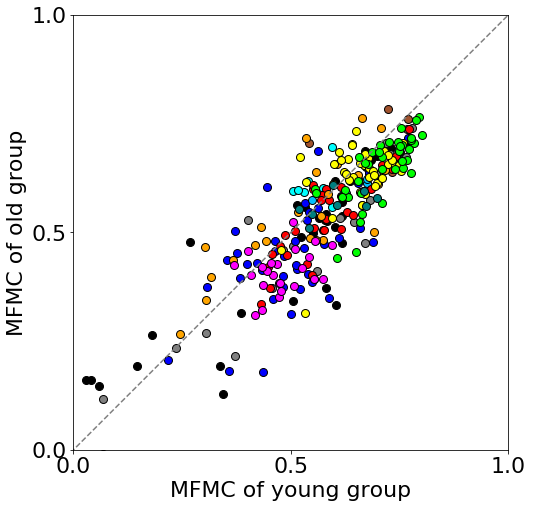

In [39]:
csv_dir = '/Path/'

fn_mc_sub1 = csv_dir+'gordon333_dmMdmF_metacorr_confoundreg_yng_n{}.csv'.format(n_grp1)
fn_mc_sub2 = csv_dir+'gordon333_dmMdmF_metacorr_confoundreg_old_n{}.csv'.format(n_grp2)

metacorr_scatter_plot_colorlabel(fn_mc_sub1, fn_mc_sub2, 'MFMC', labels)

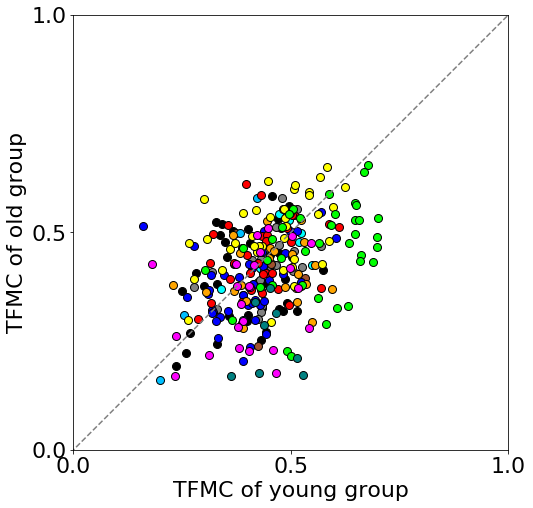

In [40]:
fn_mc_sub1 = csv_dir+'gordon333_dmTdmF_metacorr_confoundreg_yng_n{}.csv'.format(n_grp1)
fn_mc_sub2 = csv_dir+'gordon333_dmTdmF_metacorr_confoundreg_old_n{}.csv'.format(n_grp2)

metacorr_scatter_plot_colorlabel(fn_mc_sub1, fn_mc_sub2, 'TFMC', labels)

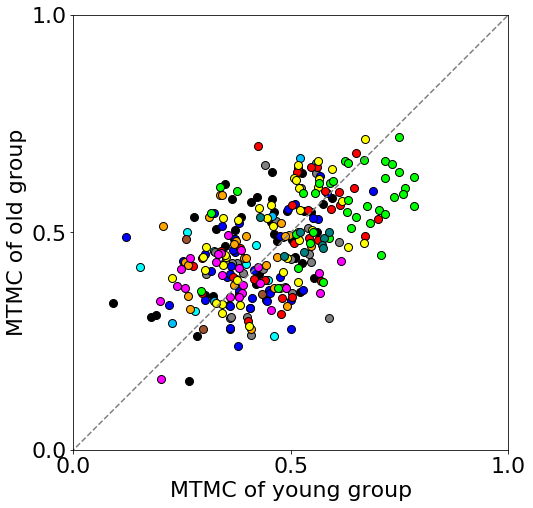

In [41]:
fn_mc_sub1 = csv_dir+'gordon333_dmMdmT_metacorr_confoundreg_yng_n{}.csv'.format(n_grp1)
fn_mc_sub2 = csv_dir+'gordon333_dmMdmT_metacorr_confoundreg_old_n{}.csv'.format(n_grp2)

metacorr_scatter_plot_colorlabel(fn_mc_sub1, fn_mc_sub2, 'MTMC', labels)

r = 0.9206033856642564


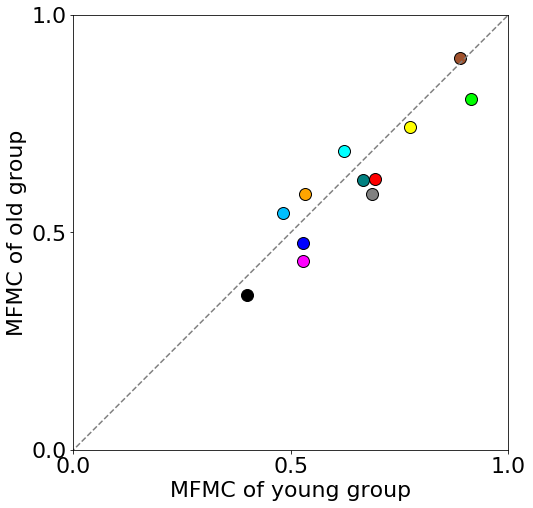

In [50]:
csv_dir = '/Path/'

fn_mc_sub1 = csv_dir+'gordon333_dmMdmF_metacorr_confoundreg_yng_n{}.csv'.format(n_grp1)
fn_mc_sub2 = csv_dir+'gordon333_dmMdmF_metacorr_confoundreg_old_n{}.csv'.format(n_grp2)

metacorr_scatter_plot_colorlabel_rsn(fn_mc_sub1, fn_mc_sub2, 'MFMC', labels, wgts)

r = 0.34760144937260484


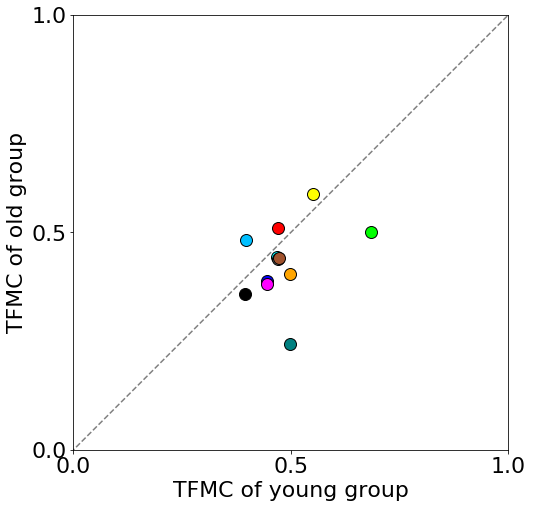

In [51]:
fn_mc_sub1 = csv_dir+'gordon333_dmTdmF_metacorr_confoundreg_yng_n{}.csv'.format(n_grp1)
fn_mc_sub2 = csv_dir+'gordon333_dmTdmF_metacorr_confoundreg_old_n{}.csv'.format(n_grp2)

metacorr_scatter_plot_colorlabel_rsn(fn_mc_sub1, fn_mc_sub2, 'TFMC', labels, wgts)

r = 0.853738127225687


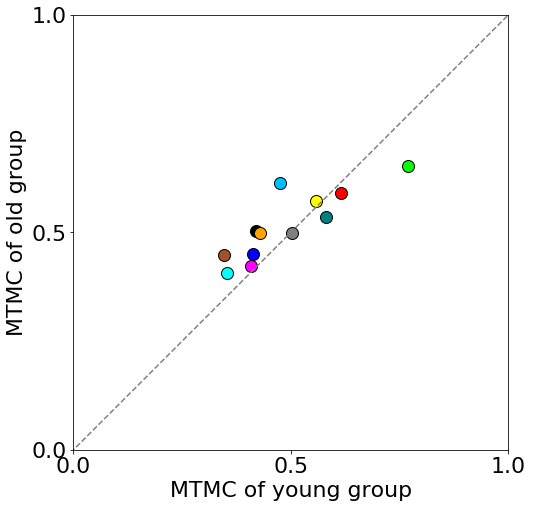

In [52]:
fn_mc_sub1 = csv_dir+'gordon333_dmMdmT_metacorr_confoundreg_yng_n{}.csv'.format(n_grp1)
fn_mc_sub2 = csv_dir+'gordon333_dmMdmT_metacorr_confoundreg_old_n{}.csv'.format(n_grp2)

metacorr_scatter_plot_colorlabel_rsn(fn_mc_sub1, fn_mc_sub2, 'MTMC', labels, wgts)